--------------------------------------------------------------------Deep_CNN_based_GRU-LSTM_Model----------------------------------------------------------

Importing Essential Libraries

In [107]:
import librosa
import numpy as np
from glob import glob
from tqdm import tqdm
import soundfile as sf
import scipy
from scipy.io import wavfile
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from IPython.display import Audio, display
import IPython
import librosa.display
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten, TimeDistributed, Bidirectional, LSTM, GRU, Dense, Dropout, Input, concatenate
from tensorflow import keras
from keras.layers import Reshape
from keras.regularizers import l2
import seaborn as sns
import pickle

Audio Preprocessng

In [1]:
def audio_reading_and_resampling(file_directory, target_sr=44000):
    audio, sr = librosa.load(file_directory, sr=None)

    audio_resampled = librosa.resample(audio, sr, 44000)

    return audio_resampled, target_sr

def removing_silence(audio_file, threshold_value=25):
    non_silent_indices = librosa.effects.split(audio_file, top_db=threshold_value)
    audio_trimming_performed = np.concatenate([audio_file[start:end] for start, end in non_silent_indices])
    
    return audio_trimming_performed

def applying_wiener_filter(audio_file):
    audio_denoised_effect = librosa.effects.preemphasis(audio_file)
    
    return audio_denoised_effect

filenames = glob('Audio/*.wav')

file = filenames[0]

for file in tqdm(filenames):
    audio_resampled, sr_resampled_rate = audio_reading_and_resampling(file)

    audio_trimmed_performed = removing_silence(audio_resampled)

    audio_denoisation_performed = applying_wiener_filter(audio_trimmed_performed)

    sf.write(file, audio_denoisation_performed, 44000)
    

  0%|          | 0/7000 [00:00<?, ?it/s]C:\Users\KIIT\AppData\Local\Temp\ipykernel_9024\2502313440.py:12: FutureWarning: Pass orig_sr=44100, target_sr=44000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_resampled = librosa.resample(audio, sr, 44000)
  0%|          | 1/7000 [00:00<1:24:35,  1.38it/s]C:\Users\KIIT\AppData\Local\Temp\ipykernel_9024\2502313440.py:12: FutureWarning: Pass orig_sr=44100, target_sr=44000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_resampled = librosa.resample(audio, sr, 44000)
 25%|██▌       | 1750/7000 [02:59<07:47, 11.23it/s]C:\Users\KIIT\AppData\Local\Temp\ipykernel_9024\2502313440.py:12: FutureWarning: Pass orig_sr=48000, target_sr=44000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_resampled = librosa.resample(audio, sr, 44000)
100%|██████████| 7000/7000 [11:45<00:00,  9.92it/s]


Mel_Spectrogram Formation

In [99]:
audio, sr = librosa.load('Audio/F_01_OISHI_S_1_ANGRY_1.wav', sr=None)
audio2=audio[0:33411]
print(audio2.shape)
print(audio)
print(audio2)
print(sr)

(33411,)
[-5.1879883e-04 -6.1035156e-05  3.0517578e-05 ... -1.2207031e-04
 -3.0517578e-04 -3.0517578e-05]
[-5.1879883e-04 -6.1035156e-05  3.0517578e-05 ... -5.9509277e-03
 -1.2512207e-03 -4.6081543e-03]
44000


In [ ]:
i=0
audio3=[]
file_names = glob('Audio/*.wav')
for file_name_inst2 in tqdm(file_names):
    audio_file_path = file_name_inst2  
    y, sr = librosa.load(audio_file_path, sr=None)
    mel_spectrogram = librosa.feature.melspectrogram(y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)

    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

    mel_spectrogram_db_resized = librosa.util.fix_length(mel_spectrogram_db, 259, axis=1)

    mel_spectrogram_np = np.array(mel_spectrogram_db_resized)
    audio3.append(mel_spectrogram_np)

In [5]:
audio3=np.array(audio3)
audio3.shape

(7000, 128, 259)

In [7]:
audio3[0]

array([[-74.257965, -70.24777 , -68.33787 , ...,   0.      ,   0.      ,
          0.      ],
       [-69.97268 , -65.894226, -67.69721 , ...,   0.      ,   0.      ,
          0.      ],
       [-69.49436 , -67.624985, -69.402985, ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [-70.33508 , -71.95159 , -74.143105, ...,   0.      ,   0.      ,
          0.      ],
       [-72.47736 , -76.4699  , -79.72313 , ...,   0.      ,   0.      ,
          0.      ],
       [-73.17717 , -79.099525, -80.      , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)

In [9]:
audio5=audio3
audio5[6999]

array([[-75.178535, -55.341763, -55.17168 , ...,   0.      ,   0.      ,
          0.      ],
       [-58.519154, -43.495724, -37.348232, ...,   0.      ,   0.      ,
          0.      ],
       [-48.26634 , -34.581276, -26.989681, ...,   0.      ,   0.      ,
          0.      ],
       ...,
       [-64.13558 , -57.64069 , -52.451233, ...,   0.      ,   0.      ,
          0.      ],
       [-66.24769 , -65.937   , -61.989017, ...,   0.      ,   0.      ,
          0.      ],
       [-67.86801 , -73.56617 , -80.      , ...,   0.      ,   0.      ,
          0.      ]], dtype=float32)

Data Labelling & Spectral Visualization

In [ ]:
labels_data = []
for each_file in file_names:
    each_file = each_file.split('/')[-1][:-3]
    labels_data.append(each_file.split('_')[-2])

In [10]:
file_name = file_names[0]
data_file = []

for file_name in tqdm(file_names):
    temp_file = scipy.io.wavfile.read(file_name, mmap=False)
    data_file.append(temp_file[1])

indx = []
for each in labels_data:
    indx.append(list(np.unique(labels_data)).index('FEAR'))

100%|██████████| 7000/7000 [00:01<00:00, 3583.28it/s]


SURPRISE


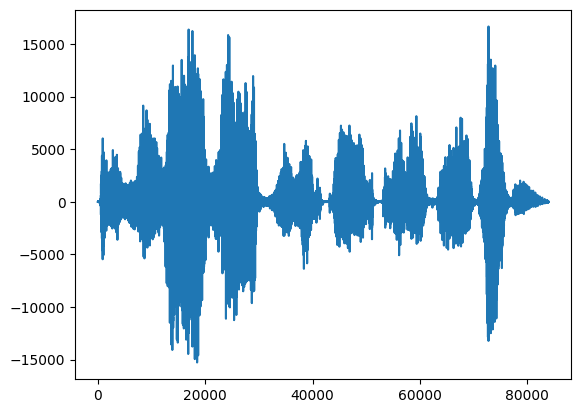

In [11]:
indx = 5000
print(labels_data[indx])
plt.plot(data_file[indx])

IPython.display.Audio(file_names[indx])

In [12]:
labels_data[5]

'DISGUST'

SAD


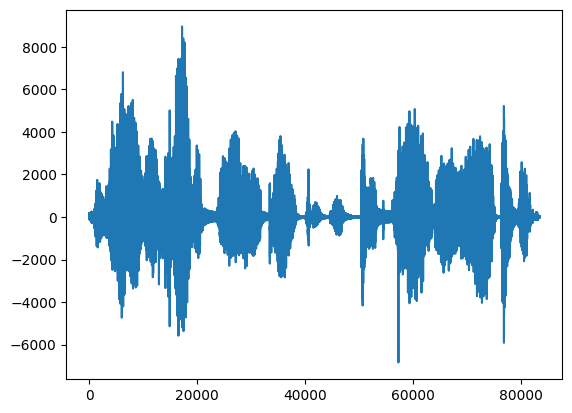

In [13]:
indx = 5909
print(labels_data[indx])
plt.plot(data_file[indx])

IPython.display.Audio(file_names[indx])

SAD


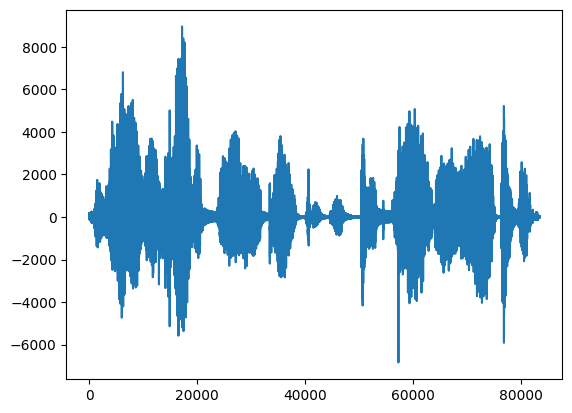

In [14]:
index = 5929
print(labels_data[indx])
plt.plot(data_file[indx])

IPython.display.Audio(file_names[indx])

Audio Spectrums

In [15]:
def create_waveplot(data_file, sr_rate, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for the audio file with {} sentiment'.format(e), size=15)
    librosa.display.waveplot(data_file, sr=sr_rate)
    plt.show()

def create_spectrogram(data, sr_rate, e):
    X_file = librosa.stft(data)
    Xdb_file = librosa.amplitude_to_db(abs(X_file))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for the audio file with {} sentiment'.format(e), size=15)
    librosa.display.specshow(Xdb_file, sr=sr_rate, x_axis='time', y_axis='hz')   
    plt.colorbar()

44000


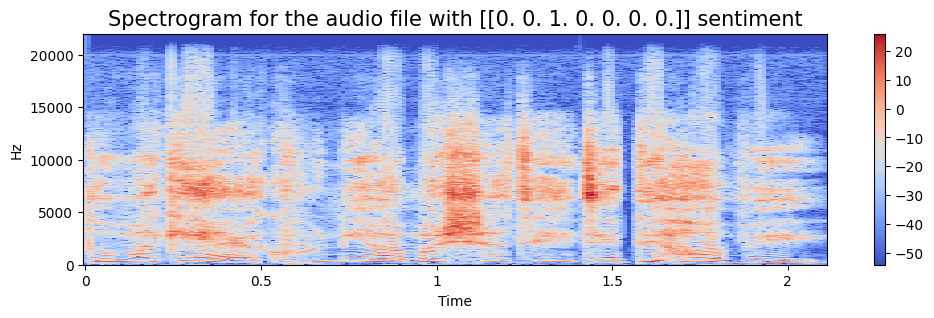

In [101]:
spectogram = []
indx = 500
emotion=labels_data[indx]
path = file_names[indx]
data, sampling_rate = librosa.load(path,sr=None)
print(sampling_rate)
a = create_spectrogram(data, 44000, emotion)

spectogram.append(a)

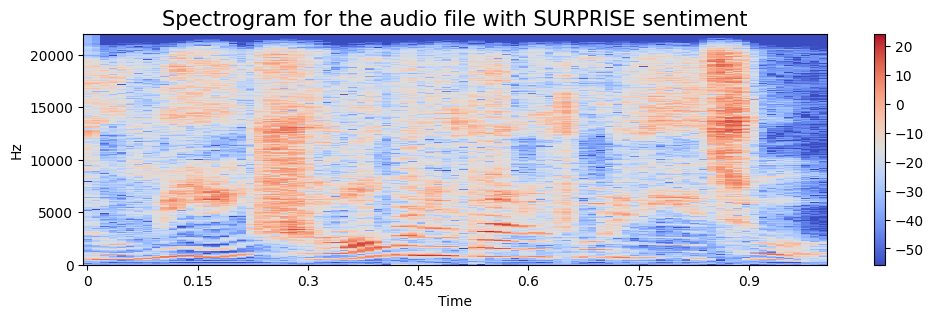

In [17]:
spectogram = []
indx = 800

emotion=labels_data[indx]
path = file_names[indx]
data, sampling_rate = librosa.load(path, sr=None)

a = create_spectrogram(data, 44000, 'AMAZEMENT')

spectogram.append(a)

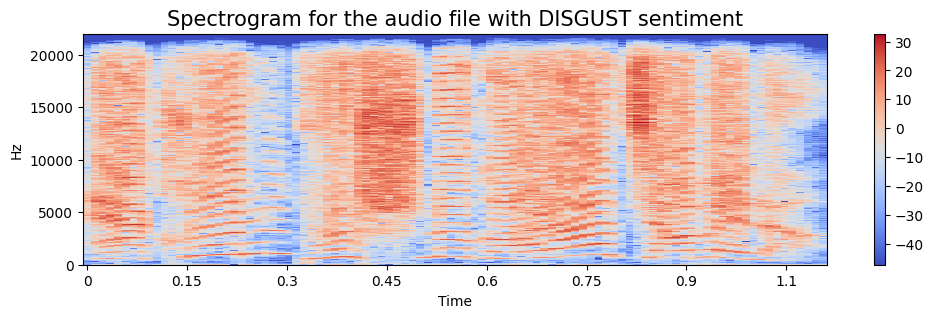

In [18]:
spectogram = []
indx = 2000
emotion=labels_data[indx]
path = file_names[indx]
data, sampling_rate = librosa.load(path, sr=None)

a = create_spectrogram(data, 44000, 'HATE')

spectogram.append(a)

Audio Spectrograms (Mel-Spectrograms)

44000


C:\Users\KIIT\AppData\Local\Temp\ipykernel_20604\2789354881.py:4: FutureWarning: Pass y=[ 2.3193359e-03 -9.1552734e-05  1.5258789e-04 ...  7.6293945e-04
  9.1552734e-05 -6.7138672e-04] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = librosa.feature.melspectrogram(Audio, sr=sr, n_fft=2048, hop_length=512, n_mels=10)


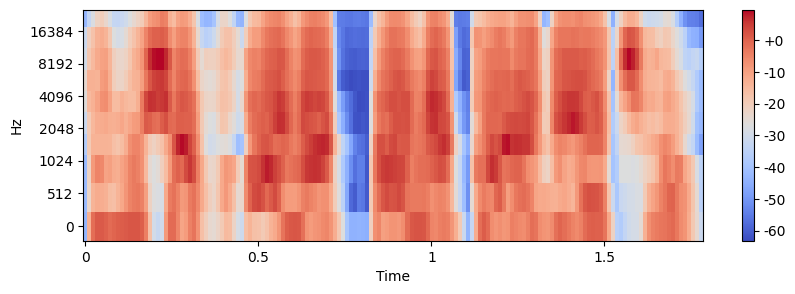

Angry


In [103]:
Audio_file = "Audio/F_01_OISHI_S_2_ANGRY_1.wav"
Audio, sr = librosa.load(Audio_file, sr=None)
print(sr)
mel_spectrogram = librosa.feature.melspectrogram(Audio, sr=sr, n_fft=2048, hop_length=512, n_mels=10)
mel_spectrogram.shape
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
log_mel_spectrogram.shape
plt.figure(figsize=(10, 3))
librosa.display.specshow(log_mel_spectrogram, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()
print('Angry')

C:\Users\KIIT\AppData\Local\Temp\ipykernel_20604\3790709818.py:3: FutureWarning: Pass y=[-0.0078125   0.00094604  0.00152588 ... -0.00222778 -0.00256348
 -0.00305176] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = librosa.feature.melspectrogram(Audio, sr=sr, n_fft=2048, hop_length=512, n_mels=10)


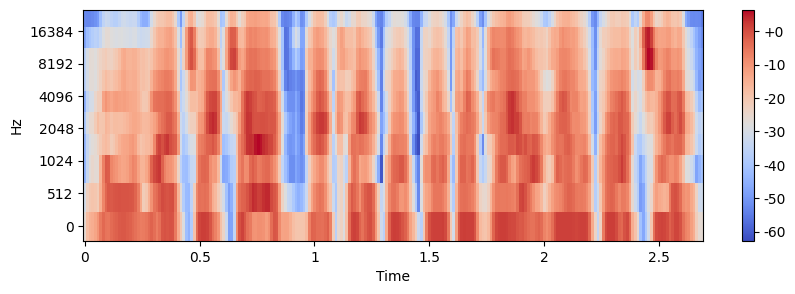

Unhapiness


In [105]:
Audio_file = "Audio/F_01_OISHI_S_1_SAD_3.wav"
Audio, sr = librosa.load(Audio_file, sr=None)
mel_spectrogram = librosa.feature.melspectrogram(Audio, sr=sr, n_fft=2048, hop_length=512, n_mels=10)
mel_spectrogram.shape
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
log_mel_spectrogram.shape
plt.figure(figsize=(10, 3))
librosa.display.specshow(log_mel_spectrogram, 
                         x_axis="time",
                         y_axis="mel", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()
print('Unhapiness')

Model Preparation

In [19]:
labels_data=np.array(labels_data)
categories = labels_data.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
one_hot_encoded = encoder.fit_transform(categories)

c:\Users\KIIT\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [20]:
labels_data=one_hot_encoded

In [90]:
labels_data

array([[[1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 0., 1.]]])

In [21]:
labels_data.shape

(7000, 7)

In [22]:
audio5=audio5.reshape(7000, 128, 259, 1)
labels_data=labels_data.reshape(7000, 1, 7)

In [23]:
labels_data[0]

array([[1., 0., 0., 0., 0., 0., 0.]])

In [24]:
audio5[0]

array([[[-74.257965],
        [-70.24777 ],
        [-68.33787 ],
        ...,
        [  0.      ],
        [  0.      ],
        [  0.      ]],

       [[-69.97268 ],
        [-65.894226],
        [-67.69721 ],
        ...,
        [  0.      ],
        [  0.      ],
        [  0.      ]],

       [[-69.49436 ],
        [-67.624985],
        [-69.402985],
        ...,
        [  0.      ],
        [  0.      ],
        [  0.      ]],

       ...,

       [[-70.33508 ],
        [-71.95159 ],
        [-74.143105],
        ...,
        [  0.      ],
        [  0.      ],
        [  0.      ]],

       [[-72.47736 ],
        [-76.4699  ],
        [-79.72313 ],
        ...,
        [  0.      ],
        [  0.      ],
        [  0.      ]],

       [[-73.17717 ],
        [-79.099525],
        [-80.      ],
        ...,
        [  0.      ],
        [  0.      ],
        [  0.      ]]], dtype=float32)

In [25]:
X_train, X_test, y_train, y_test=train_test_split(audio5, labels_data, test_size=0.10, random_state=42)

In [26]:
def Deep_CNN_S_Hb_LSTM_GRU_Model(input_shape):

    model_in = Input(shape=input_shape)
    model1_in= Input(shape=input_shape)
    
    model=Conv2D(128, (3, 3), strides=(1, 1), padding='same')(model_in)
    model=BatchNormalization()(model)
    model=Activation('elu')(model)
    model=MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(model)

    model=Conv2D(128, (3, 3), strides=(1, 1), padding='same')(model)
    model=BatchNormalization()(model)
    model=Activation('elu')(model)
    model=MaxPooling2D(pool_size=(4, 4), strides=(4, 4))(model)

    model=Conv2D(64, (3, 3), strides=(1, 1), padding='same')(model)
    model=BatchNormalization()(model)
    model=Activation('elu')(model)
    model=MaxPooling2D(pool_size=(4, 4), strides=(4, 4))(model)

    model=Conv2D(64, (3, 3), strides=(1, 1), padding='same')(model)
    model=BatchNormalization()(model)
    model=Activation('elu')(model)
    model=MaxPooling2D(pool_size=(4, 4), strides=(4, 4))(model)

    model1=Conv2D(128, (3, 3), strides=(1, 1), padding='same')(model1_in)
    model1=BatchNormalization()(model1)
    model1=Activation('elu')(model1)
    model1=MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(model1)

    model1=Conv2D(128, (3, 3), strides=(1, 1), padding='same')(model1)
    model1=BatchNormalization()(model1)
    model1=Activation('elu')(model1)
    model1=MaxPooling2D(pool_size=(4, 4), strides=(4, 4))(model1)
    
    model=TimeDistributed(Flatten())(model)
    model1=TimeDistributed(Flatten())(model1)

    model=Bidirectional(LSTM(units=375, return_sequences=True))(model)
    model=Dropout(0.20)(model)

    model1=Bidirectional(GRU(units=156, activation='tanh', return_sequences=True))(model1)
    model1=Dropout(0.35)(model1)

    model=Dense(30,activation='relu', kernel_regularizer=l2(0.01))(model)
    model1=Dense(30,activation='relu', kernel_regularizer=l2(0.01))(model1)
    model1=Reshape((1, 480))(model1)

    model2=concatenate([model, model1])

    model2=Dense(7,activation='softmax')(model2)
    
    model_ul=tf.keras.models.Model(inputs=[model_in, model1_in], outputs=model2)

    return model_ul

A_model = Deep_CNN_S_Hb_LSTM_GRU_Model(X_train.shape[-3:])

A_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

A_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 259, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 259, 12  1280        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 259, 12  512        ['conv2d[0][0]']                 
 alization)                     8)                                                            

Model Traning and Cross Validation

In [27]:
X_train.shape

(6300, 128, 259, 1)

In [28]:
y_train.shape

(6300, 1, 7)

In [29]:
X_train

array([[[[-63.3301  ],
         [-51.58967 ],
         [-46.972042],
         ...,
         [  0.      ],
         [  0.      ],
         [  0.      ]],

        [[-61.29862 ],
         [-43.47696 ],
         [-34.028282],
         ...,
         [  0.      ],
         [  0.      ],
         [  0.      ]],

        [[-57.946247],
         [-38.580257],
         [-33.382023],
         ...,
         [  0.      ],
         [  0.      ],
         [  0.      ]],

        ...,

        [[-62.59043 ],
         [-60.839928],
         [-62.130096],
         ...,
         [  0.      ],
         [  0.      ],
         [  0.      ]],

        [[-63.989494],
         [-67.40196 ],
         [-71.7478  ],
         ...,
         [  0.      ],
         [  0.      ],
         [  0.      ]],

        [[-65.26645 ],
         [-71.20106 ],
         [-80.      ],
         ...,
         [  0.      ],
         [  0.      ],
         [  0.      ]]],


       [[[-64.308975],
         [-63.78915 ],
         [-57.

In [30]:
model_history=A_model.fit([X_train, X_train], y_train, epochs=50, batch_size=64, validation_split=0.22)

Epoch 1/50
77/77 [==============================] - 1500s 19s/step - loss: 2.4591 - accuracy: 0.2633 - val_loss: 2.6059 - val_accuracy: 0.1530
Epoch 2/50
77/77 [==============================] - 1533s 20s/step - loss: 1.8428 - accuracy: 0.3547 - val_loss: 2.5928 - val_accuracy: 0.1890
Epoch 3/50
77/77 [==============================] - 1550s 20s/step - loss: 1.5918 - accuracy: 0.4322 - val_loss: 3.1611 - val_accuracy: 0.1869
Epoch 4/50
77/77 [==============================] - 1529s 20s/step - loss: 1.4092 - accuracy: 0.4935 - val_loss: 1.5762 - val_accuracy: 0.4113
Epoch 5/50
77/77 [==============================] - 1552s 20s/step - loss: 1.2159 - accuracy: 0.5574 - val_loss: 1.5769 - val_accuracy: 0.4149
Epoch 6/50
77/77 [==============================] - 1541s 20s/step - loss: 1.0700 - accuracy: 0.6190 - val_loss: 2.3740 - val_accuracy: 0.3290
Epoch 7/50
77/77 [==============================] - 1558s 20s/step - loss: 0.8990 - accuracy: 0.6852 - val_loss: 1.0511 - val_accuracy: 0.6147

In [ ]:
plt.plot(model_history.history['accuracy'])
plt.plot(model_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Result Prediction

In [37]:
y_pred=A_model.predict([X_test, X_test])

22/22 [==============================] - 35s 2s/step


In [38]:
y_pred

array([[[1.6561319e-04, 4.7732665e-06, 4.1249889e-04, ...,
         2.4439869e-03, 9.9484420e-01, 3.8328308e-06]],

       [[8.7386811e-01, 8.5213222e-02, 5.8425336e-05, ...,
         1.6705493e-02, 1.1206331e-03, 2.1366170e-04]],

       [[2.3818613e-05, 9.6363408e-07, 2.4051037e-04, ...,
         5.9937942e-04, 9.9866486e-01, 1.8188657e-06]],

       ...,

       [[5.2461645e-04, 1.7271077e-02, 7.7821449e-03, ...,
         3.2420148e-04, 2.5450505e-04, 7.3627579e-01]],

       [[2.8958221e-04, 6.5230665e-06, 1.1556603e-03, ...,
         9.4233011e-04, 9.9147874e-01, 1.8347560e-05]],

       [[1.3058147e-05, 9.2177221e-04, 4.6730256e-03, ...,
         7.9708542e-07, 3.8167113e-07, 9.9337596e-01]]], dtype=float32)

In [40]:
y_test

array([[[0., 0., 0., ..., 0., 1., 0.]],

       [[1., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 1., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 1.]],

       [[0., 0., 0., ..., 0., 1., 0.]],

       [[0., 0., 0., ..., 0., 0., 1.]]])

In [42]:
y_pred2=y_pred.reshape(700,7)

In [43]:
y_pred2

array([[1.6561319e-04, 4.7732665e-06, 4.1249889e-04, ..., 2.4439869e-03,
        9.9484420e-01, 3.8328308e-06],
       [8.7386811e-01, 8.5213222e-02, 5.8425336e-05, ..., 1.6705493e-02,
        1.1206331e-03, 2.1366170e-04],
       [2.3818613e-05, 9.6363408e-07, 2.4051037e-04, ..., 5.9937942e-04,
        9.9866486e-01, 1.8188657e-06],
       ...,
       [5.2461645e-04, 1.7271077e-02, 7.7821449e-03, ..., 3.2420148e-04,
        2.5450505e-04, 7.3627579e-01],
       [2.8958221e-04, 6.5230665e-06, 1.1556603e-03, ..., 9.4233011e-04,
        9.9147874e-01, 1.8347560e-05],
       [1.3058147e-05, 9.2177221e-04, 4.6730256e-03, ..., 7.9708542e-07,
        3.8167113e-07, 9.9337596e-01]], dtype=float32)

In [44]:
probabilities = y_pred2

indices = np.argmax(probabilities, axis=1)

one_hot_probabilities = np.zeros((probabilities.shape[0], probabilities.shape[1]))
one_hot_probabilities[np.arange(probabilities.shape[0]), indices] = 1

print(one_hot_probabilities)

[[0. 0. 0. ... 0. 1. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [45]:
y_pred2=one_hot_probabilities

In [46]:
y_pred2=y_pred2.reshape(700,1,7)

In [47]:
y_pred2.shape

(700, 1, 7)

In [39]:
y_pred.shape

(700, 1, 7)

In [50]:
y_test2=y_test.reshape(700,7)
y_pred2=y_pred2.reshape(700, 7)

In [52]:
y_pred2

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [53]:
y_test2

array([[0., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [65]:
y_test2.shape

(700, 7)

Confusion Matrix Formation & Result Evaluation

In [85]:
cm = confusion_matrix(y_test2.argmax(axis=1), y_pred2.argmax(axis=1))

[Text(0, 0.5, 'Anger'),
 Text(0, 1.5, 'Hate'),
 Text(0, 2.5, 'Fear'),
 Text(0, 3.5, 'Delight'),
 Text(0, 4.5, 'Neutral'),
 Text(0, 5.5, 'Unhappiness'),
 Text(0, 6.5, 'Amazement')]

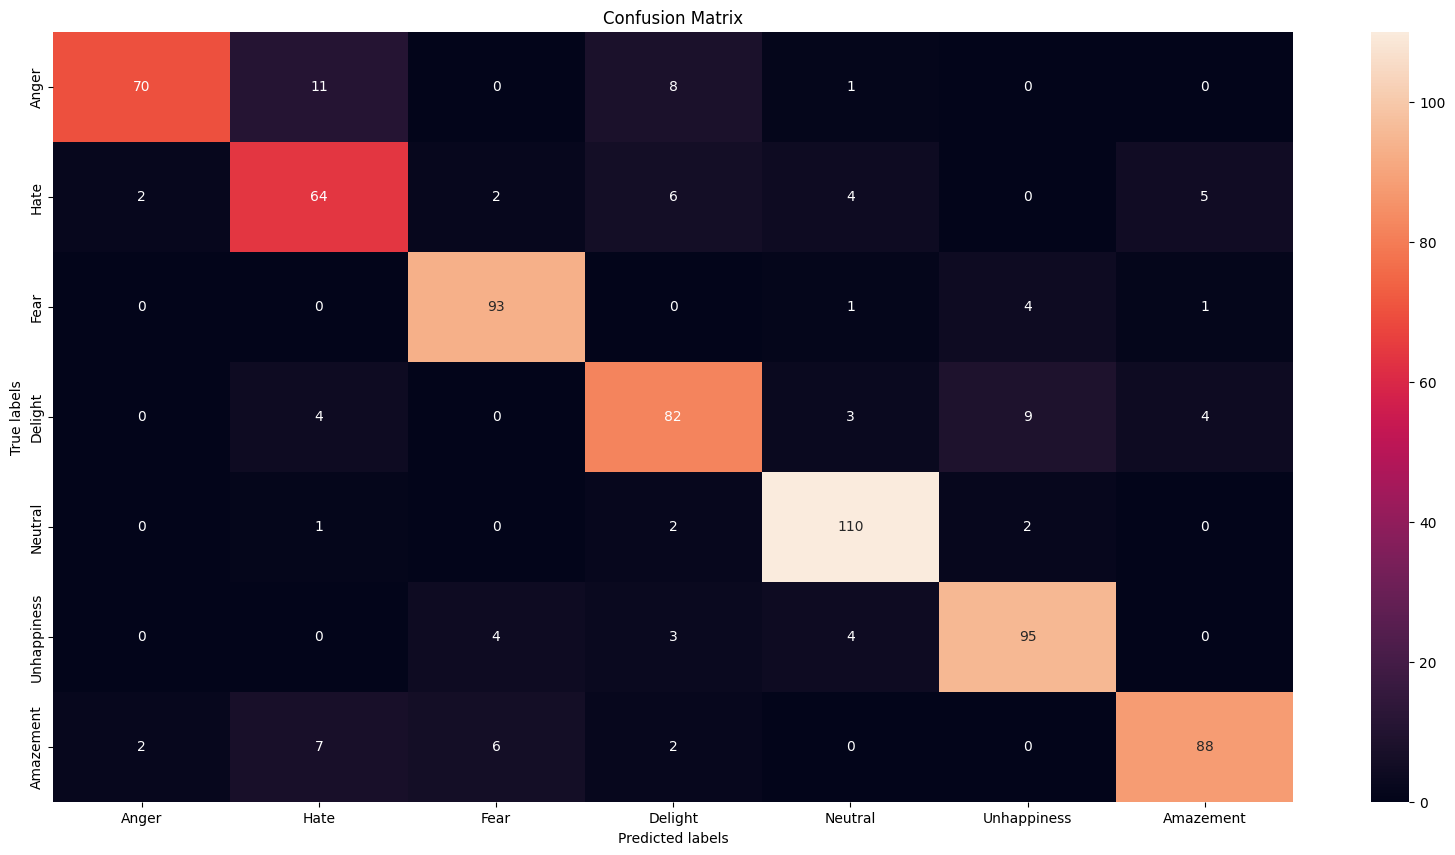

In [94]:
plt.figure(figsize=(20,10))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax); 

labels=['Anger', 'Hate', 'Fear', 'Delight', 'Neutral', 'Unhappiness', 'Amazement']
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels)

In [81]:
labels=['0: Anger', '1: Hate', '2: Fear', '3: Delight', '4: Neutral', '5: Unhappiness', '6: Amazement']
print(classification_report(y_test2, y_pred2, labels=[0,1,2,3,4,5,6]))

              precision    recall  f1-score   support

           0       0.95      0.78      0.85        90
           1       0.74      0.77      0.75        83
           2       0.89      0.94      0.91        99
           3       0.80      0.80      0.80       102
           4       0.89      0.96      0.92       115
           5       0.86      0.90      0.88       106
           6       0.90      0.84      0.87       105

   micro avg       0.86      0.86      0.86       700
   macro avg       0.86      0.85      0.86       700
weighted avg       0.86      0.86      0.86       700
 samples avg       0.86      0.86      0.86       700



Model Saving

In [ ]:
model_pkl_file = "model.pkl"  

with open(model_pkl_file, 'wb') as file:  
    pickle.dump(A_model, file)

To load Model

In [ ]:
with open(model_pkl_file, 'rb') as file:  
    model = pickle.load(file)